### Kaggle Dataset – HR Analytics: Job Change of Data Scientists

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_test.csv

Import relevant libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OrdinalEncoder 
from scipy import stats

Import and Summarize Dataset

In [2]:
df = pd.read_csv('aug_train.csv')

#Check dimensions
print(df.shape)

#Check columns
#print(df.columns)

#Print header
#print(df.head(3))

#Info
#print(df.info)

#Summarize
#print(df.describe())


(19158, 14)


Enrolled in University 

In [4]:
#Categorical variable of enrollment
df['enrolled_university'].value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64

In [5]:
#Assume null values are not enrolled, otherwise they would report as enrolled
df['enrolled_university'].isnull().sum()
df['enrolled_university'].fillna("no_enrollment", inplace = True)

#Setup dummy variables for enrollment
dummies = pd.get_dummies(df['enrolled_university'],prefix='enrolled_university')
df = df.join(dummies)

Education Level

In [6]:
#Ordinal variable of education level
df['education_level'].value_counts()

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [7]:
#Cleanup / setup list
df['education_level'] = df['education_level'].str.replace(" ","_", regex=False)
education_level_list = ['Primary_School','High_School','Graduate','Masters','Phd']
numbers = range(1,6)

#Replace null  with Graduate level of education. Basically assumes individuals with significantly differing levels from norm would disclose 
df['education_level'].isnull().sum()
df['education_level'].fillna("Graduate", inplace = True)

#Update column to reflect ordinal numerical values
education_level_list_dictionary = dict(zip(education_level_list, numbers))
df['education_level'].replace(education_level_list_dictionary, inplace=True)

Major discipline

In [8]:
#Categorical variable
df['major_discipline'].value_counts()

STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [9]:
#Assume null values are Other, STEM is likely the most important response for this variable
df['major_discipline'].isnull().sum()
df['major_discipline'].fillna("Other", inplace = True)

#Setup dummy variables for major discipline
dummies = pd.get_dummies(df['major_discipline'],prefix='major_discipline')
df = df.join(dummies)

In [10]:
#Setup new combination variable (Enrolled & Education level): Identify highly educated currently enrolled in studies
df.head()

df['High_and_continuing_education'] = (df['enrolled_university'] != 'no_enrollment') & (df['education_level'] > 3 )
df['High_and_continuing_education'] = df['High_and_continuing_education'].astype(int)

In [11]:
#Delete original dataframe columns for education related variables converted to categorical
del df['enrolled_university']
del df['major_discipline']

City variable

In [13]:
#Look at distribution variable categories
df.city.value_counts()

city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_111       3
city_129       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64

In [14]:
#Look at unique values
df.city.unique()

array(['city_103', 'city_40', 'city_21', 'city_115', 'city_162',
       'city_176', 'city_160', 'city_46', 'city_61', 'city_114',
       'city_13', 'city_159', 'city_102', 'city_67', 'city_100',
       'city_16', 'city_71', 'city_104', 'city_64', 'city_101', 'city_83',
       'city_105', 'city_73', 'city_75', 'city_41', 'city_11', 'city_93',
       'city_90', 'city_36', 'city_20', 'city_57', 'city_152', 'city_19',
       'city_65', 'city_74', 'city_173', 'city_136', 'city_98', 'city_97',
       'city_50', 'city_138', 'city_82', 'city_157', 'city_89',
       'city_150', 'city_70', 'city_175', 'city_94', 'city_28', 'city_59',
       'city_165', 'city_145', 'city_142', 'city_26', 'city_12',
       'city_37', 'city_43', 'city_116', 'city_23', 'city_99', 'city_149',
       'city_10', 'city_45', 'city_80', 'city_128', 'city_158',
       'city_123', 'city_7', 'city_72', 'city_106', 'city_143', 'city_78',
       'city_109', 'city_24', 'city_134', 'city_48', 'city_144',
       'city_91', 'city_

Possibly, city number could mean something? Let's check.

In [15]:
#Convert city variable to integer
df.city = df.city.str[5:].astype(int)

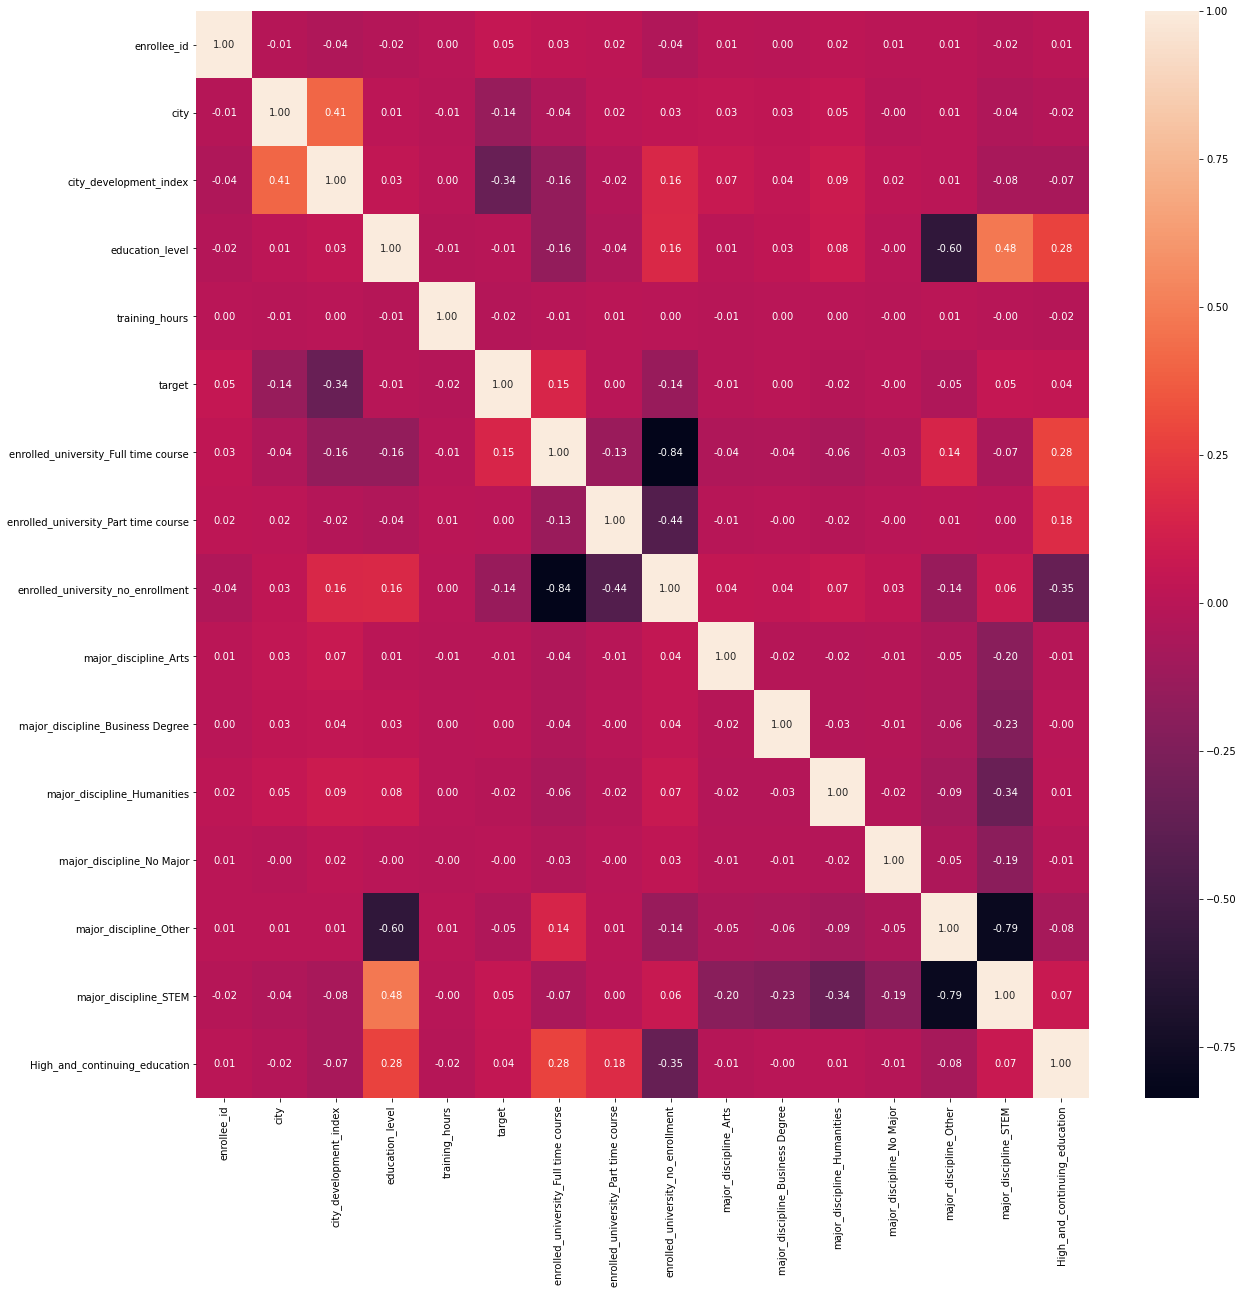

In [16]:
#Look at correlation of city variable with others in the dataset
f,ax = plt.subplots(figsize=(20,20))
corr=df.corr()
sns.heatmap(corr,annot=True,fmt='.2f')

City and City Index show some correlation of 0.41. However, since city number by itself does not signify anything, we can leverage an ordinal encoder.

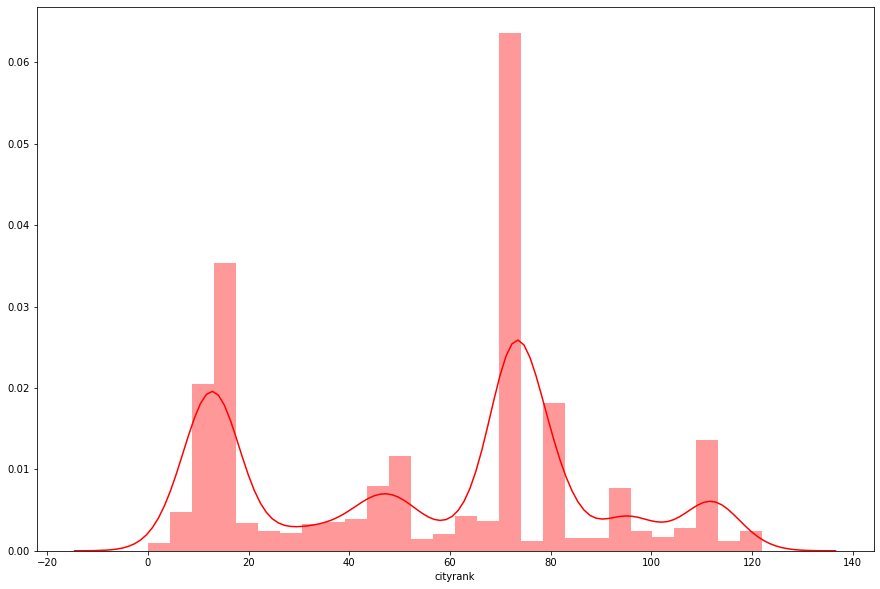

In [17]:
#Transform using ordinal encoder
values = sorted(df['city'].unique())
enc = OrdinalEncoder(categories = [values])

#Plot density function and bar plot
df['cityrank'] = pd.DataFrame(enc.fit_transform(df[['city']]))
plt.figure(figsize=(15,10))
sns.distplot(df['cityrank'], color="r")

In [18]:
df[['city','cityrank']]

,city,cityrank
0,103,73.0
1,40,27.0
2,21,14.0
3,115,81.0
4,162,113.0
...,...,...
19153,173,118.0
19154,103,73.0
19155,103,73.0
19156,65,44.0


The rank ordering looks correct. We can now drop city, as well as enrollee_id which has no correlation with the other variables.

In [19]:
df = df.drop(columns = ['city','enrollee_id'])

Let's look at city development index now

In [20]:
df['city_development_index'].describe()

count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

Index is approximately from .45 to .95, with a mean of 0.83 and SD of 0.12. So, it is a skewed distribution. 
Let's plot it.

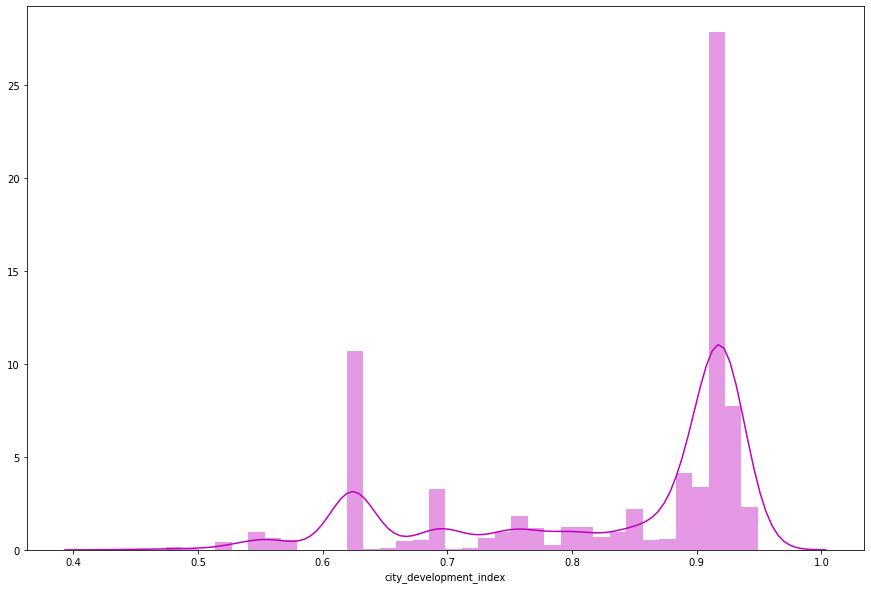

In [21]:
plt.figure(figsize=(15,10))
sns.distplot(df['city_development_index'], color="m")

The strong negative skewness will cause bias in the classification towards majority classes due to outlier effects, so let's try a BoxCox transformation.

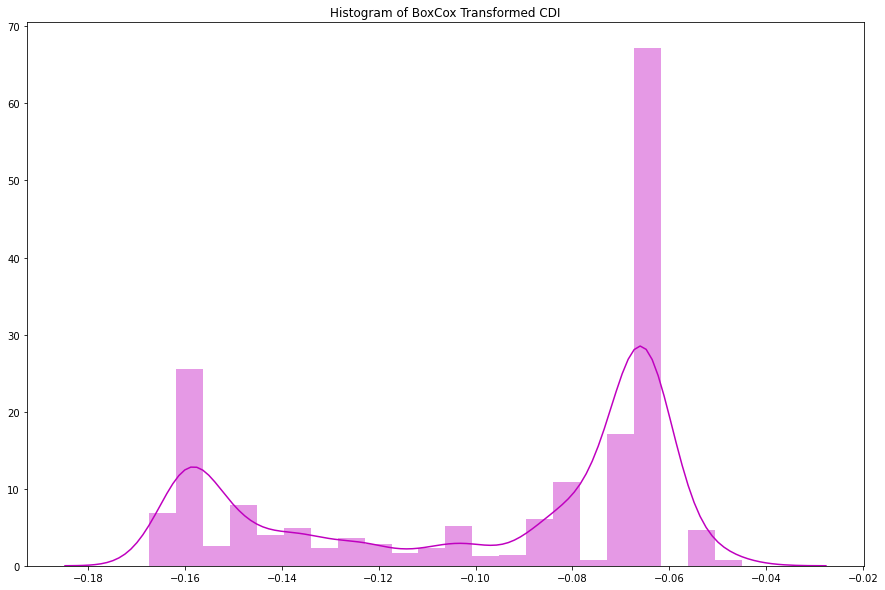

In [22]:
plt.figure(figsize=(15,10))
sns.distplot(stats.boxcox(df['city_development_index'])[0], color="m") 
plt.title('Histogram of BoxCox Transformed CDI')
plt.show()

Now the distribution is somewhat less skewed, so there will not be an outlier issue.

In [23]:
stats.boxcox(df['city_development_index'])[0]

array([-0.06580533, -0.13126178, -0.15853521, ..., -0.06580533,
       -0.12315518, -0.10208846])

In [24]:
df['CDI_transformed'] = stats.boxcox(df['city_development_index'])[0]
df = df.drop(columns = ['city_development_index'])

Let's look at the scatter plot of the two transformed variables for city and city development index:

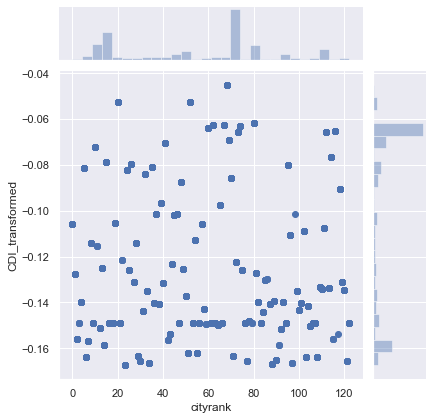

In [25]:
sns.set(rc={'figure.figsize':(20,15)})
sns.jointplot(x='cityrank', y='CDI_transformed', 
              data=df, kind='scatter');

Now let's look at gender

In [26]:
df['gender'].value_counts()

Male      13221
Female     1238
Other       191
Name: gender, dtype: int64

In [27]:
df['gender'].isna().sum()

4508

Let's replace the null values with "Unknown" gender

In [28]:
df['gender'] = df['gender'].fillna("Unknown")
df['gender'].value_counts()

Male       13221
Unknown     4508
Female      1238
Other        191
Name: gender, dtype: int64

Now we need to convert gender into dummy varaibles

In [29]:
dummies = pd.get_dummies(df['gender'], prefix = 'gender')
dummies = dummies.drop(columns = ['gender_Unknown'])
df = df.join(dummies)
df = df.drop(columns = ['gender'])

In [30]:
df.head()

,relevent_experience,education_level,experience,company_size,company_type,last_new_job,training_hours,target,enrolled_university_Full time course,enrolled_university_Part time course,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,High_and_continuing_education,cityrank,CDI_transformed,gender_Female,gender_Male,gender_Other
0,Has relevent experience,3,>20,NaN,NaN,1,36,1.0,0,0,...,0,0,0,1,0,73.0,-0.065805,0,1,0
1,No relevent experience,3,15,50-99,Pvt Ltd,>4,47,0.0,0,0,...,0,0,0,1,0,27.0,-0.131262,0,1,0
2,No relevent experience,3,5,NaN,NaN,never,83,0.0,1,0,...,0,0,0,1,0,14.0,-0.158535,0,0,0
3,No relevent experience,3,<1,NaN,Pvt Ltd,never,52,1.0,0,0,...,0,0,0,0,0,81.0,-0.127373,0,0,0
4,Has relevent experience,4,>20,50-99,Funded Startup,4,8,0.0,0,0,...,0,0,0,1,0,113.0,-0.133773,0,1,0


Let's check for outliers now.

In [31]:
z = np.abs(stats.zscore(df['CDI_transformed'], nan_policy = 'omit'))

In [32]:
#Looking for rows > 5 sigma
scores = pd.DataFrame(z)
scores.columns = ['CDI_transformed']
scores.index = df['CDI_transformed'].index
scores[(scores > 5).any(axis=1)]

#No outliers

,CDI_transformed


Relevant Experience

In [34]:
df['relevent_experience'].unique()

array(['Has relevent experience', 'No relevent experience'], dtype=object)

In [35]:
#assigned categorical variables 
a={'Has relevent experience':1,'No relevent experience':0}
df['relevent_experience']=df['relevent_experience'].map(a)

#Dummy columns setup later due to use of column in further analysis

Experience

In [36]:
df['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [37]:
df['experience'].value_counts(normalize = True)

>20    0.172105
5      0.074897
4      0.073482
3      0.070916
6      0.063688
2      0.059027
7      0.053842
10     0.051590
9      0.051328
8      0.042005
15     0.035929
11     0.034777
14     0.030692
1      0.028754
<1     0.027340
16     0.026607
12     0.025873
13     0.020898
17     0.017912
19     0.015922
18     0.014665
20     0.007752
Name: experience, dtype: float64

In [38]:
#Convert to Boolean
df.replace({'experience': '<1'}, '0', inplace=True) 
df.replace({'experience': '>20'}, '20', inplace=True) 

In [39]:
df['experience'].isnull().sum()

65

In [40]:
df['experience'] = df['experience'].astype(float)

In [41]:
#filling in the na with mean
df['experience'].fillna(df.mean(),inplace=True)

#Drop rows that left (65)
df = df[df['experience'].notna()]

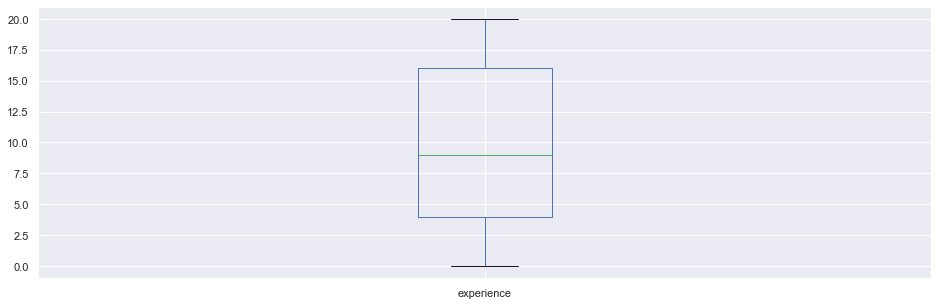

In [42]:
#Check for outlier - none
df['experience'].plot.box(figsize=(16,5))
plt.show()

New feature based on Relevant Experience and Overall Experience. Identify highly experienced professionals with low relevant experience

In [43]:
#Function to assign categories
def myfunc(relevent_experience, experience):
    if relevent_experience==1 and experience>=9:
        myvalue=1
    elif relevent_experience==1 and experience<9:
        myvalue=2
    elif relevent_experience==0 and experience>=9:
        myvalue=3
    else:
        myvalue=4
    return myvalue

In [44]:
#Apply function
df['experience_contrast'] = df.apply(lambda x: myfunc(x['relevent_experience'], x['experience']), axis=1)

In [45]:
#Setup dummy columns for new categorical feature
dummies = pd.get_dummies(df['experience_contrast'],prefix='experience_contrast')
df = df.join(dummies)
del df['experience_contrast']
df.head()

,relevent_experience,education_level,experience,company_size,company_type,last_new_job,training_hours,target,enrolled_university_Full time course,enrolled_university_Part time course,...,High_and_continuing_education,cityrank,CDI_transformed,gender_Female,gender_Male,gender_Other,experience_contrast_1,experience_contrast_2,experience_contrast_3,experience_contrast_4
0,1,3,20.0,NaN,NaN,1,36,1.0,0,0,...,0,73.0,-0.065805,0,1,0,1,0,0,0
1,0,3,15.0,50-99,Pvt Ltd,>4,47,0.0,0,0,...,0,27.0,-0.131262,0,1,0,0,0,1,0
2,0,3,5.0,NaN,NaN,never,83,0.0,1,0,...,0,14.0,-0.158535,0,0,0,0,0,0,1
3,0,3,0.0,NaN,Pvt Ltd,never,52,1.0,0,0,...,0,81.0,-0.127373,0,0,0,0,0,0,1
4,1,4,20.0,50-99,Funded Startup,4,8,0.0,0,0,...,0,113.0,-0.133773,0,1,0,1,0,0,0


In [46]:
#Setup dummy columns for relevant_experience
dummies = pd.get_dummies(df['relevent_experience'], prefix = 'relevent_experience')
df = df.join(dummies)
df = df.drop(columns = ['relevent_experience'])

Last New Job

In [47]:
#List of values
df['last_new_job'].unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

In [48]:
#Check null values
df['last_new_job'].isnull().sum()

399

In [49]:
#Replacement of values at extremes
df.replace({'last_new_job': 'never'}, '0', inplace=True)
df.replace({'last_new_job': '>4'}, '5', inplace=True)

#Set value as float
df['last_new_job'] = df['last_new_job'].astype(float)

#Fill missing values with mean
df['last_new_job'].fillna(df['last_new_job'].mean(),inplace=True)

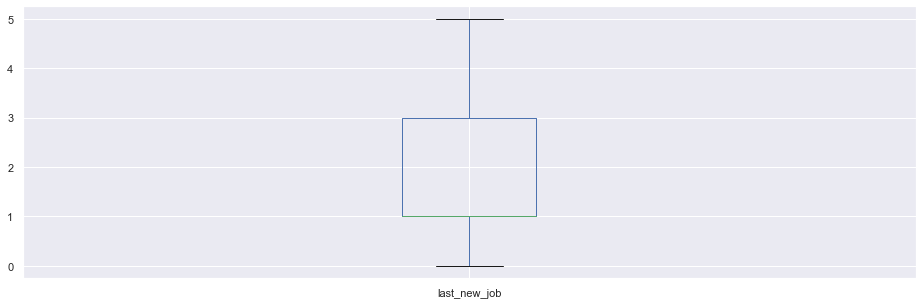

In [50]:
#Check for outlier - none
df['last_new_job'].plot.box(figsize=(16,5))
plt.show()

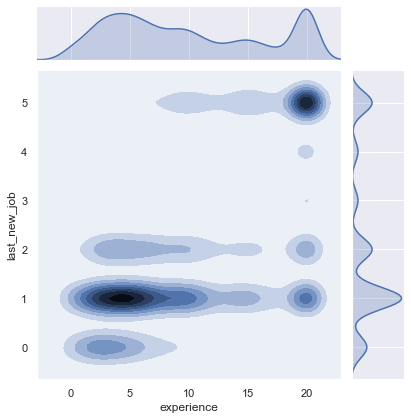

In [51]:
#Since experience is correlated to last new job:
sns.set(rc={'figure.figsize':(20,15)})
sns.jointplot(x='experience', y='last_new_job', 
              data=df, kind='kde');

Higher "last_new_job" means higher experience. So we can split up the >20 into different levels based on last new job.

In [52]:
df[df.experience != 20].groupby("last_new_job").experience.mean()

last_new_job
0.000000     4.848681
1.000000     7.056701
2.000000     8.312629
2.001123     4.978082
3.000000     9.319662
4.000000    10.084788
5.000000    12.159104
Name: experience, dtype: float64

In [53]:
df[df.experience == 20].groupby("last_new_job").experience.count()

last_new_job
0.000000     131
1.000000     841
2.000000     466
2.001123      34
3.000000     194
4.000000     226
5.000000    1542
Name: experience, dtype: int64

In [54]:
#Assuming >20, implies 3 levels of 21,  25 and 30:
df.loc[(df['last_new_job'] <3) & (df['experience'] == 20), 'experience'] = 21
df.loc[(df['last_new_job'] <5) & (df['last_new_job'] >= 3) & (df['experience'] == 20), 'experience'] = 25
df.loc[(df['last_new_job'] ==5) & (df['experience'] == 20), 'experience'] = 30

In [55]:
df[df.experience >20].groupby("last_new_job").experience.mean()

last_new_job
0.000000    21.0
1.000000    21.0
2.000000    21.0
2.001123    21.0
3.000000    25.0
4.000000    25.0
5.000000    30.0
Name: experience, dtype: float64

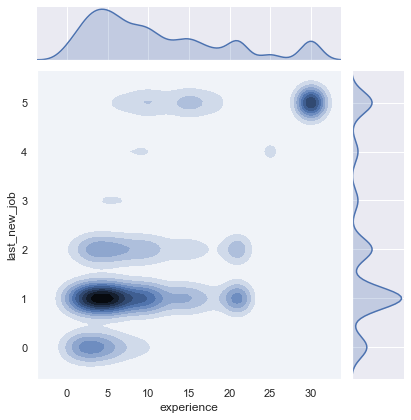

In [56]:
#Let's recheck the pairwise density plot:
sns.set(rc={'figure.figsize':(20,15)})
sns.jointplot(x='experience', y='last_new_job', 
              data=df, kind='kde');

Training hours

In [58]:
# training hours
df["training_hours"].describe()
# The standard deviation being almost as high as the mean may indicate positive skew, as training hours cannot be negative. The quartiles also show greater variance to the right, which may suggest a transformation.

count    19093.000000
mean        65.345257
std         60.051868
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

In [59]:
sum(df["training_hours"].isna())

0

In [60]:
 training_z = np.abs(stats.zscore(df.training_hours, nan_policy = 'omit'))
 len(df.training_hours[training_z>5])

 #There are no NAs or extreme outliers to remove.

0

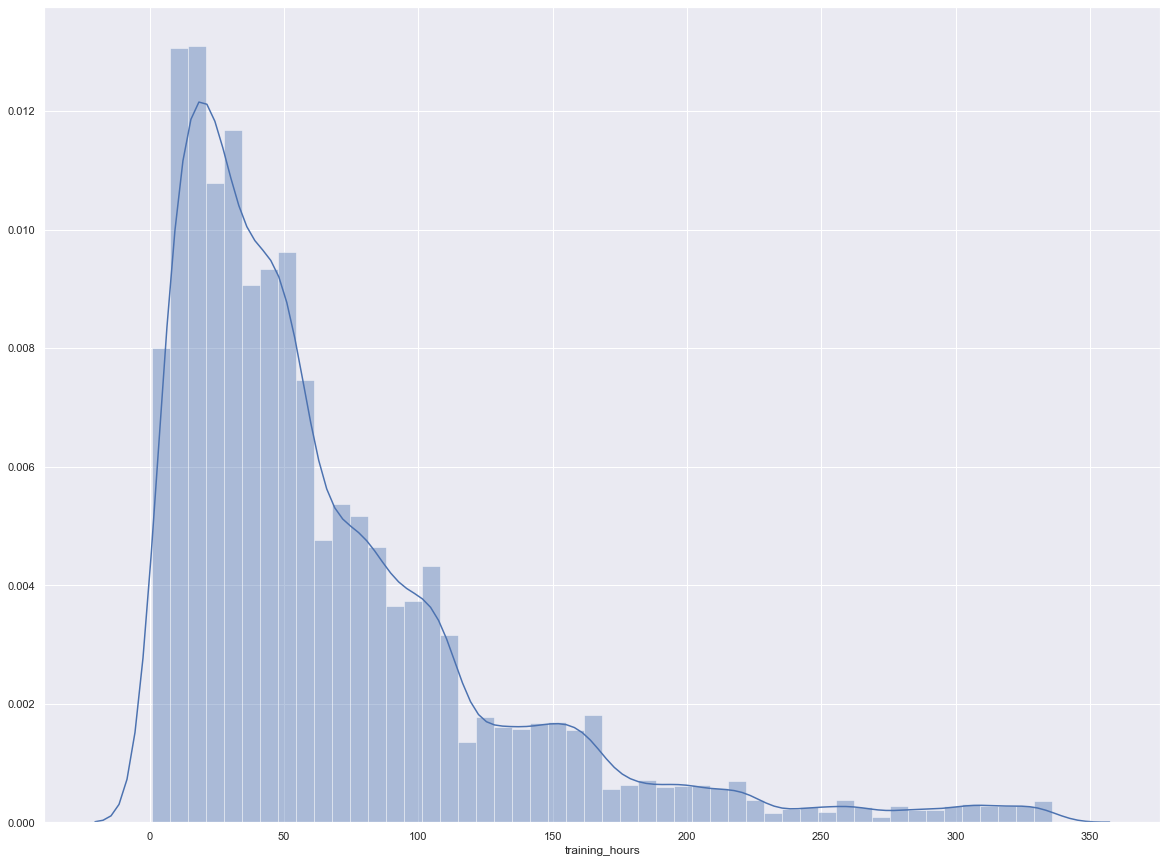

In [61]:
sns.distplot(df.training_hours)

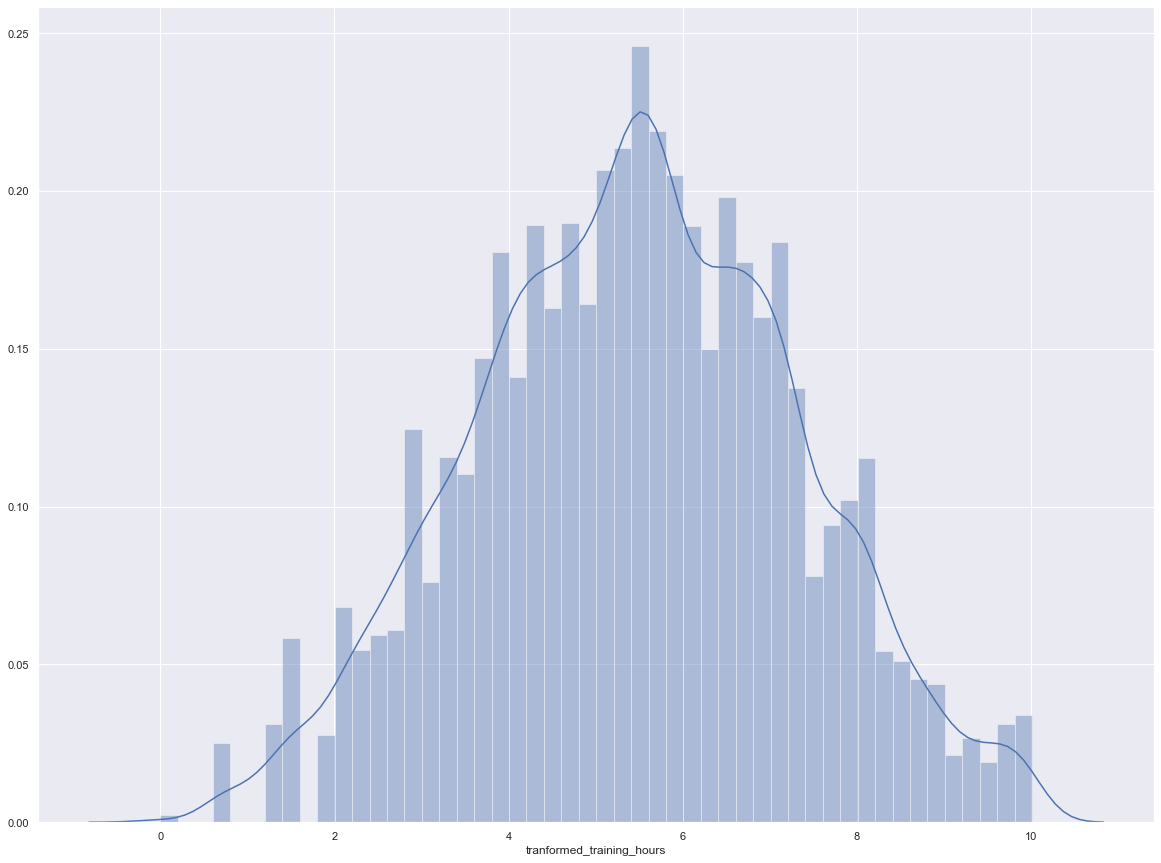

In [62]:
df["tranformed_training_hours"] = stats.boxcox(df['training_hours'])[0]
sns.distplot(df.tranformed_training_hours)
# The data has fewer outliers.

In [63]:
# Delete training hours and use transformed_training_hourse
del df["training_hours"]

Company size and company type

In [64]:
sum(df["company_size"].isna())

5915

In [65]:
sum(df["company_type"].isna())

6104

Both company size and type have a significant number of missing values. 

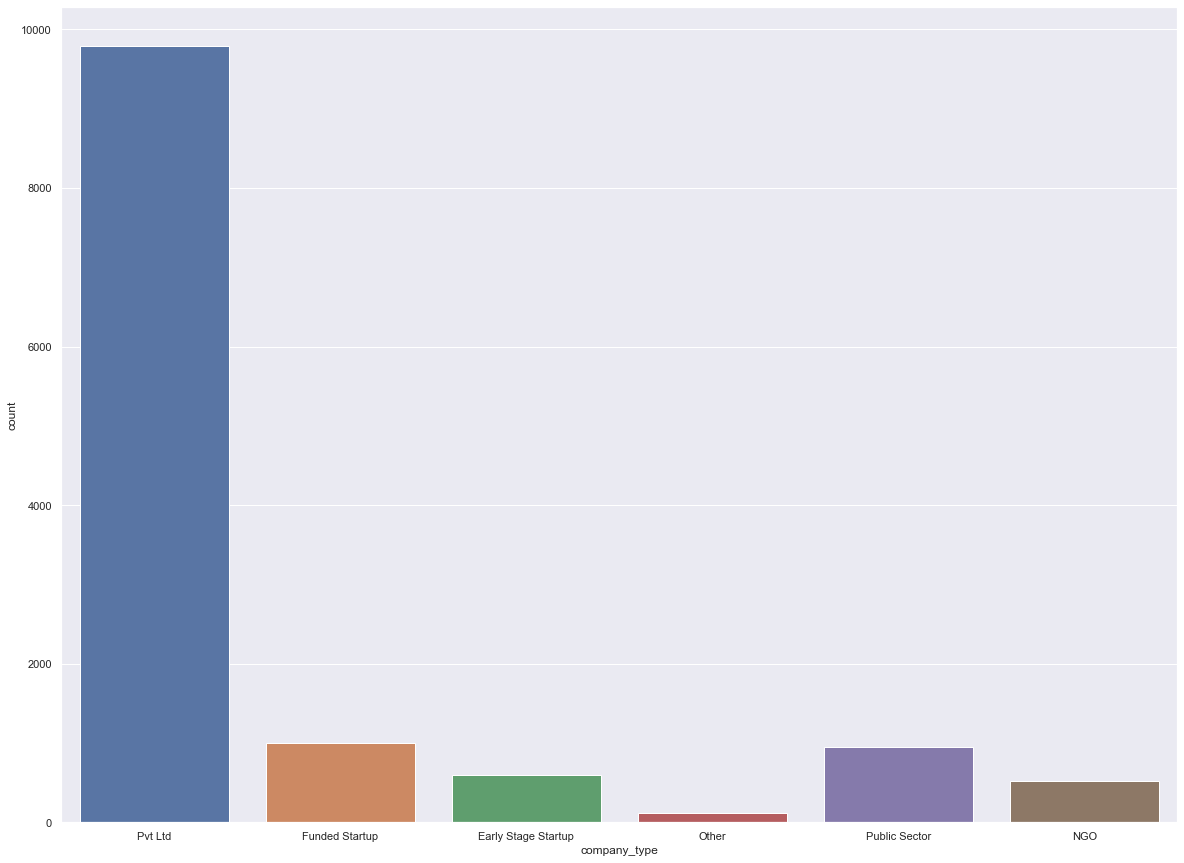

In [66]:
sns.countplot(df["company_type"])

In [67]:
df["company_type"].value_counts()

Pvt Ltd                9796
Funded Startup          999
Public Sector           953
Early Stage Startup     601
NGO                     519
Other                   121
Name: company_type, dtype: int64

The vast majority of company_type are Pvt Ltd. Given how common this type is, NA values are filled with Pvt Ltd. 

In [68]:
df["company_type"] = df["company_type"].fillna("Pvt Ltd")

In [69]:
size_numeric_map = {"50-99":75,
                   "100-500":300,
                    "500-999":750,
                   "10000+":12000,
                   "10/49":35,
                   "1000-4999":3000,
                   "5000-9999":7500,
                   "<10":5}
df["company_size"]= df["company_size"].replace(size_numeric_map)

In [70]:
df["company_size"].value_counts()

75.0       3078
300.0      2563
12000.0    2011
35.0       1466
3000.0     1323
5.0        1304
750.0       874
7500.0      559
Name: company_size, dtype: int64

In [71]:
size_keys = df.groupby("company_type").company_size.mean()
size_keys

company_type
Early Stage Startup      42.399666
Funded Startup          142.203219
NGO                    1962.302231
Other                  2704.336283
Public Sector          3621.881068
Pvt Ltd                2912.804254
Name: company_size, dtype: float64

In [72]:
predicted_keys = [size_keys[key] for key in df["company_type"]]
df["company_size"] = np.where(df["company_size"].isna(),predicted_keys,df["company_size"])
df["company_size"].value_counts()

2912.804254     5744
75.000000       3078
300.000000      2563
12000.000000    2011
35.000000       1466
3000.000000     1323
5.000000        1304
750.000000       874
7500.000000      559
3621.881068      129
1962.302231       26
2704.336283        8
142.203219         5
42.399666          3
Name: company_size, dtype: int64

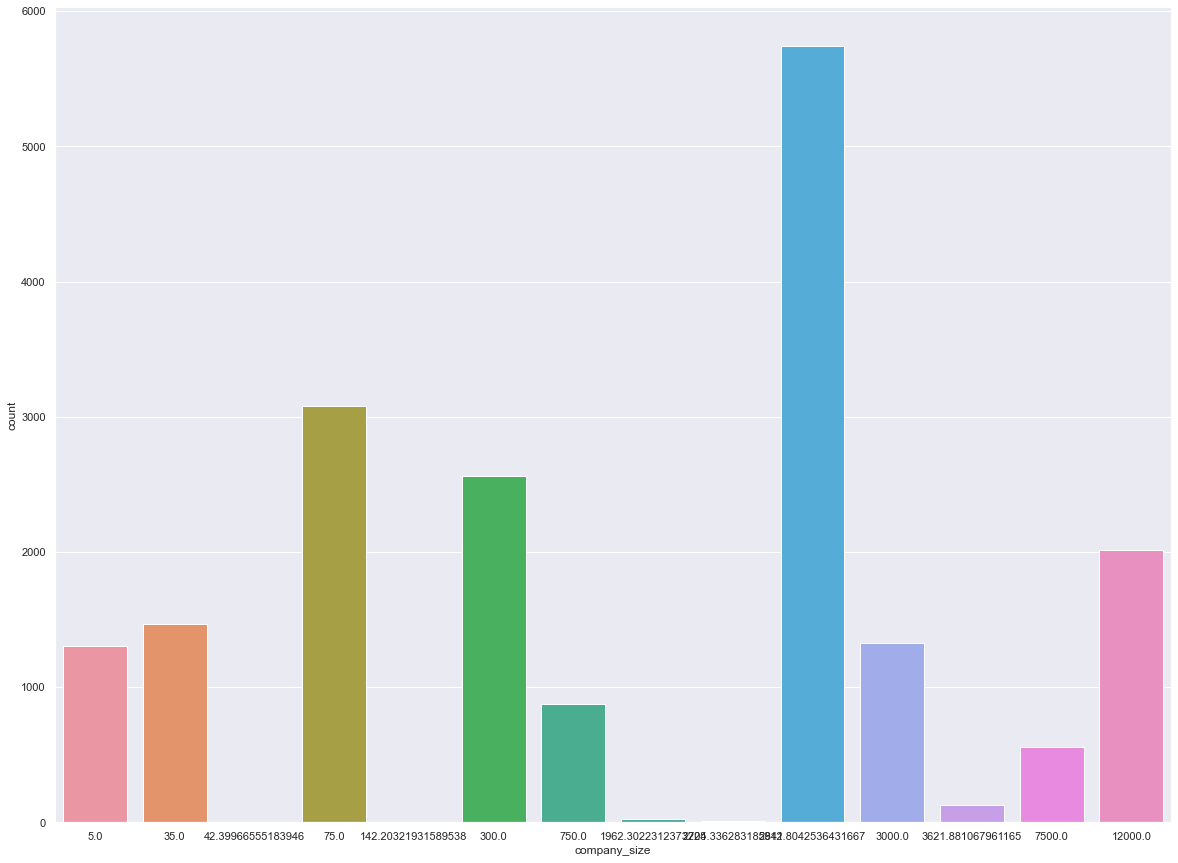

In [73]:
sns.countplot(df["company_size"]) 

In [74]:
#Setup dummy columns for company type
dummies = pd.get_dummies(df['company_type'], prefix = 'company_type',drop_first=True)
df = df.join(dummies)
df = df.drop(columns = ['company_type'])

In [75]:
#Delete dummy variables that are correlated within their set
df.drop(columns = ['enrolled_university_Part time course', 'major_discipline_No Major' , 'experience_contrast_3', 'relevent_experience_0'], inplace = True)

In [76]:
# Check null values for full dataframe
df.isnull().sum()

education_level                         0
experience                              0
company_size                            0
last_new_job                            0
target                                  0
enrolled_university_Full time course    0
enrolled_university_no_enrollment       0
major_discipline_Arts                   0
major_discipline_Business Degree        0
major_discipline_Humanities             0
major_discipline_Other                  0
major_discipline_STEM                   0
High_and_continuing_education           0
cityrank                                0
CDI_transformed                         0
gender_Female                           0
gender_Male                             0
gender_Other                            0
experience_contrast_1                   0
experience_contrast_2                   0
experience_contrast_4                   0
relevent_experience_1                   0
tranformed_training_hours               0
company_type_Funded Startup       

Initial variable correlations / selection

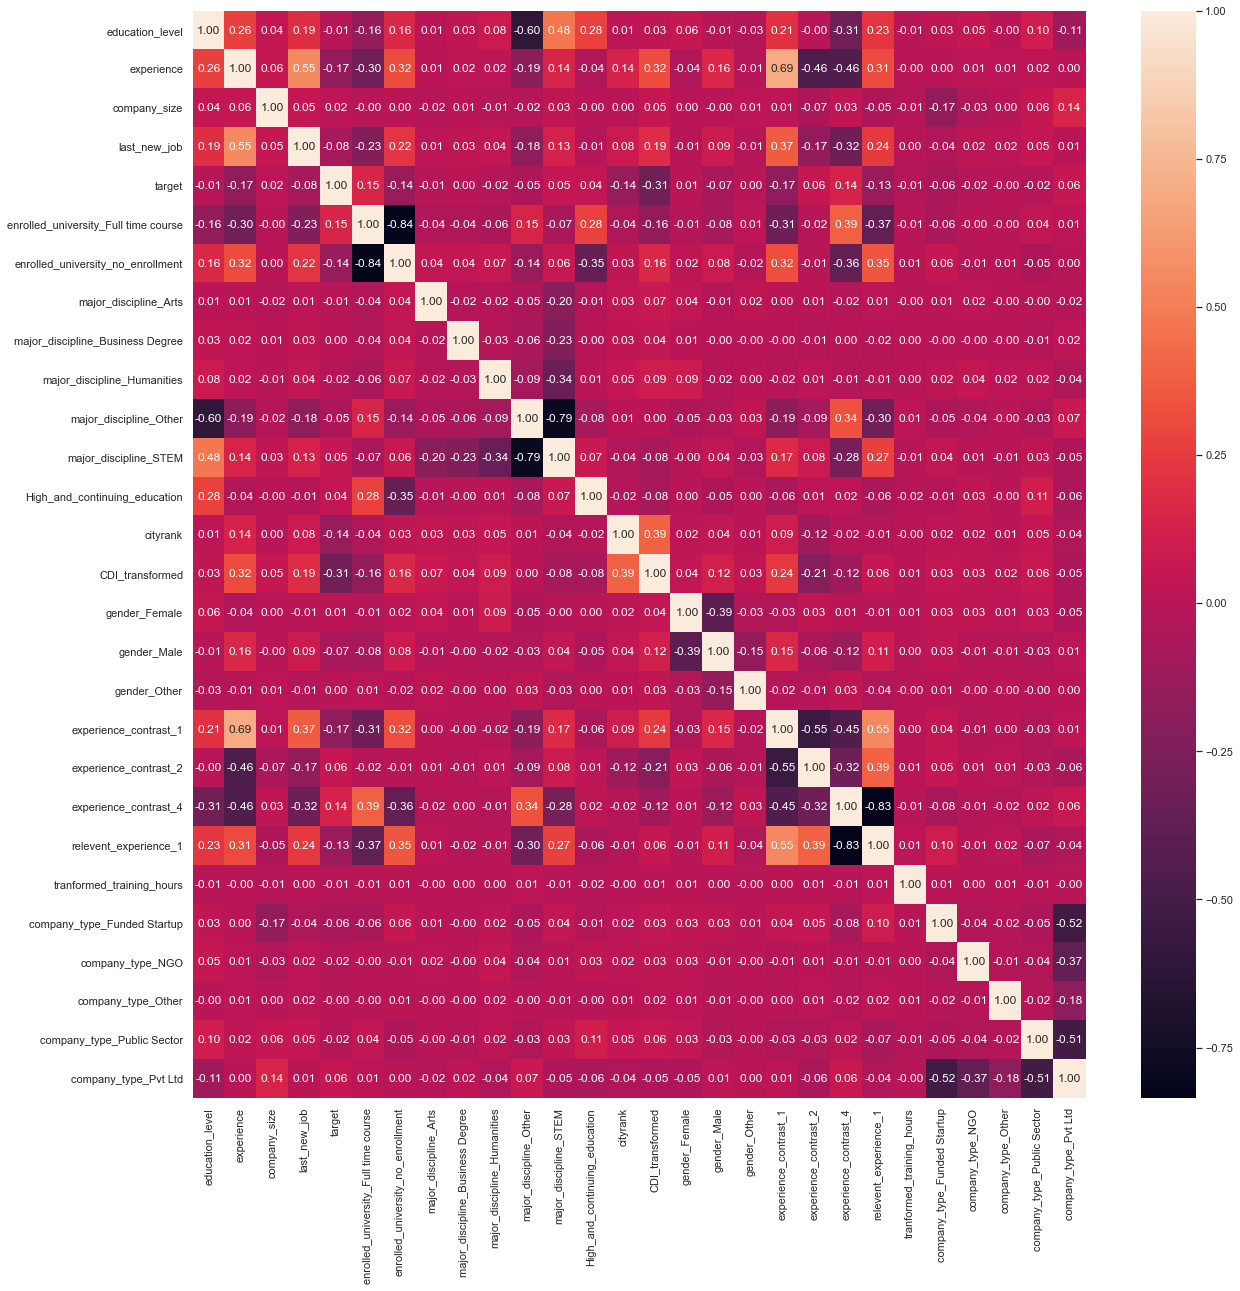

In [77]:
#Look at correlations across the variables
f,ax = plt.subplots(figsize=(20,20))
corr=df.corr()
sns.heatmap(corr,annot=True,fmt='.2f')

In [78]:
# Check correlation of target with other variables
correlations_list = df.corr()['target'][:]
abs_correlations_list_sorted = correlations_list.abs().sort_values(ascending=False)
abs_correlations_list_sorted

target                                  1.000000
CDI_transformed                         0.310024
experience_contrast_1                   0.171201
experience                              0.166062
enrolled_university_Full time course    0.149740
cityrank                                0.142726
experience_contrast_4                   0.137214
enrolled_university_no_enrollment       0.136809
relevent_experience_1                   0.128987
last_new_job                            0.082129
gender_Male                             0.073691
experience_contrast_2                   0.059794
company_type_Funded Startup             0.059147
company_type_Pvt Ltd                    0.058105
major_discipline_STEM                   0.050489
major_discipline_Other                  0.047521
High_and_continuing_education           0.044721
company_type_NGO                        0.024748
major_discipline_Humanities             0.017353
company_size                            0.016286
company_type_Public 

# Clustering

In [ ]:
df2 = df.drop(['target'], axis = 1)
df2.shape

##### 1. t-SNE

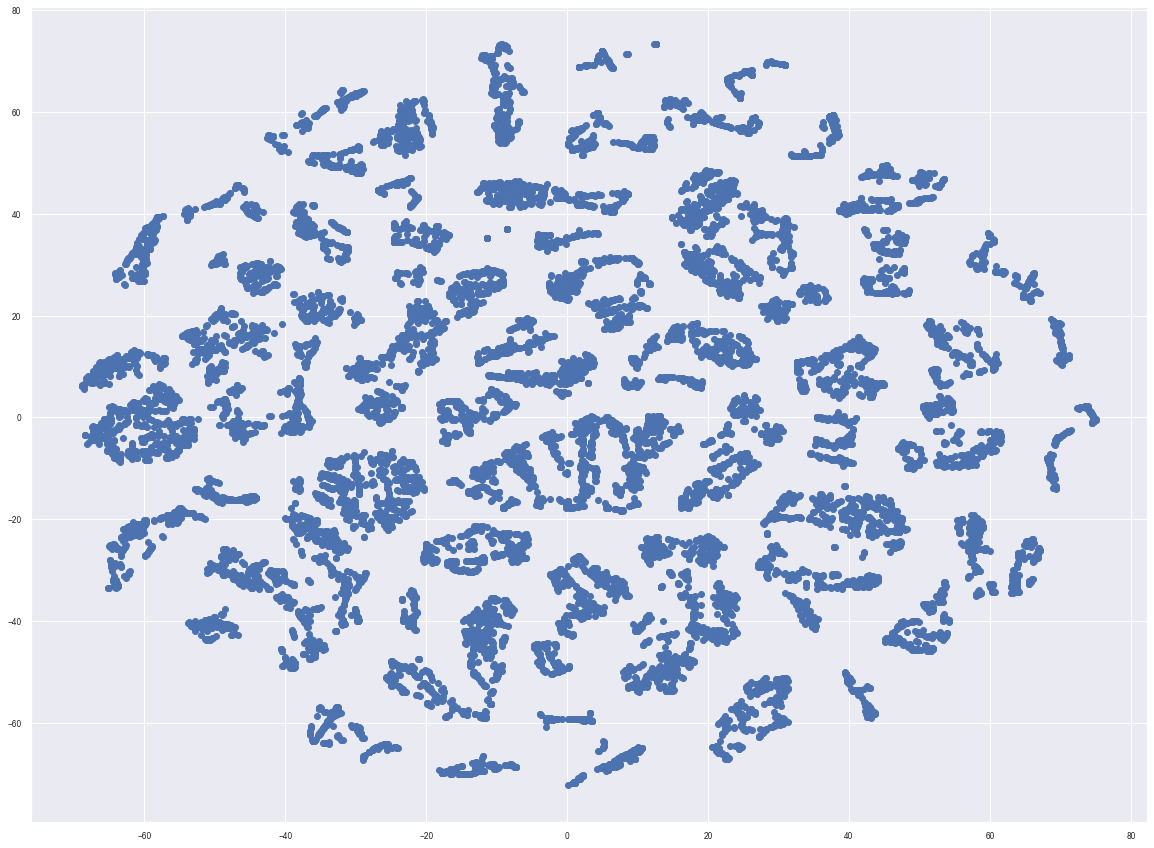

In [165]:
from sklearn.manifold import TSNE
model=TSNE(learning_rate=100)
Tsne_transformed=model.fit_transform(df2)
xs =Tsne_transformed[:,0]
ys=Tsne_transformed[:,1]
plt.scatter(xs,ys)
plt.show()

t-SNE shows multiple small clusters, which is not possible to model.

#### 2. k-means

In [132]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [134]:
scaler = StandardScaler()
df3 = pd.DataFrame(scaler.fit_transform(df2), columns = df2.columns)
df3.shape

(19093, 31)

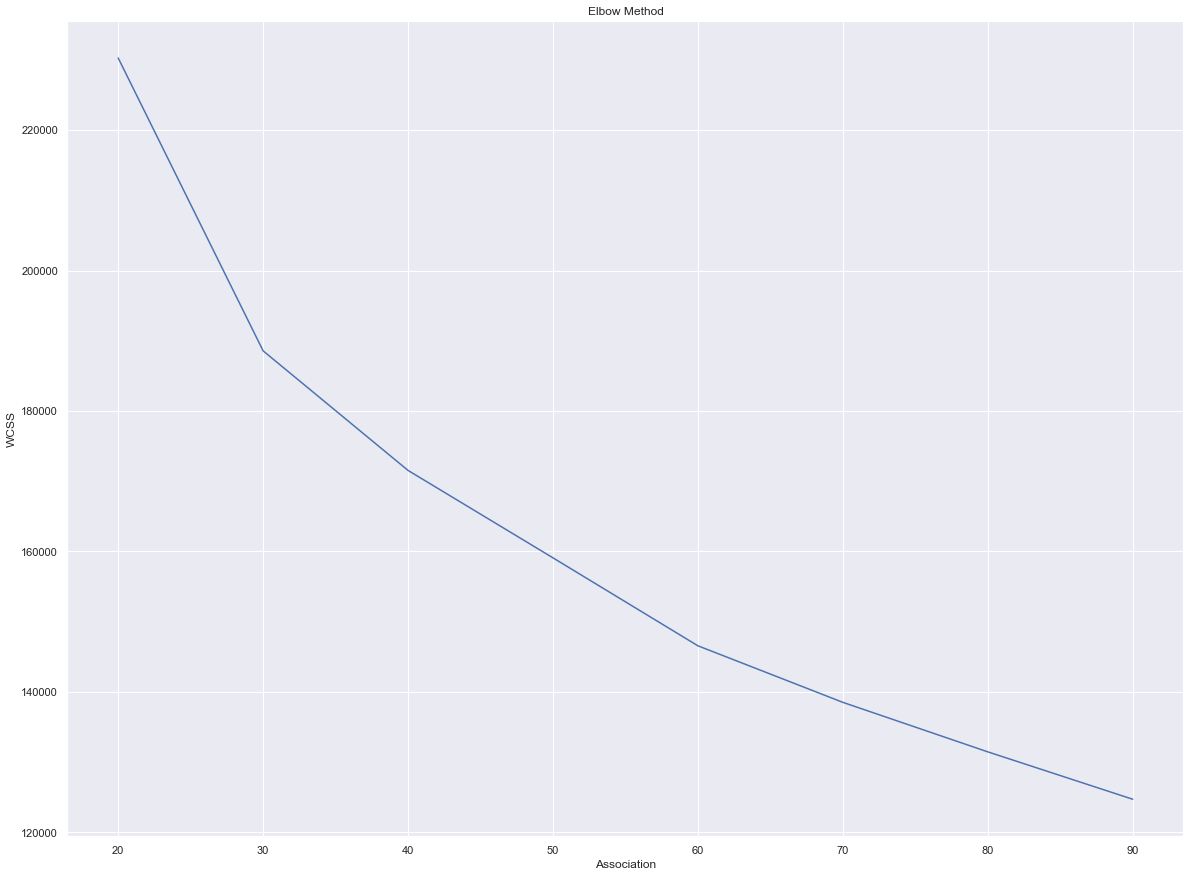

In [135]:
wcss = []
for i in range(20, 100, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(df3)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(20, 100, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

Using the Elbow Method, let's pick 70 clusters

In [136]:
kmeans = KMeans(n_clusters =  70, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(df3)
df2_cluster = df2.copy(deep=True) 
df2_cluster['cluster'] = y_kmeans
df2_cluster

,education_level,experience,company_size,last_new_job,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,...,experience_contrast_4,relevent_experience_0,relevent_experience_1,log_training_hours,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,cluster
0,3,20.0,2912.804254,1.0,0,0,1,0,0,0,...,0,0,1,3.583519,0,0,0,0,1,2
1,3,15.0,75.000000,5.0,0,0,1,0,0,0,...,0,1,0,3.850148,0,0,0,0,1,13
2,3,5.0,2912.804254,0.0,1,0,0,0,0,0,...,1,1,0,4.418841,0,0,0,0,1,31
3,3,0.0,2912.804254,0.0,0,0,1,0,1,0,...,1,1,0,3.951244,0,0,0,0,1,9
4,4,20.0,75.000000,4.0,0,0,1,0,0,0,...,0,0,1,2.079442,1,0,0,0,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,3,14.0,2912.804254,1.0,0,0,1,0,0,1,...,0,1,0,3.737670,0,0,0,0,1,38
19154,3,14.0,2912.804254,4.0,0,0,1,0,0,0,...,0,0,1,3.951244,0,0,0,0,1,27
19155,3,20.0,75.000000,4.0,0,0,1,0,0,0,...,0,0,1,3.784190,0,0,0,0,1,27
19156,2,0.0,750.000000,2.0,0,0,1,0,0,0,...,0,0,1,4.574711,0,0,0,0,1,60


Let's do some PCA feature reduction to be able to visualize the 70 clusters by most important features

In [137]:
from sklearn.decomposition import PCA

In [138]:
def plot_scaled_variance(pca):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Cumulative Explained Variance Ratio')
    ax.set_title('Cumulative Fraction of Explained Variance')
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    return ax

In [140]:
pca = PCA(n_components = 31)
pca.fit(df3)

PCA(n_components=31)

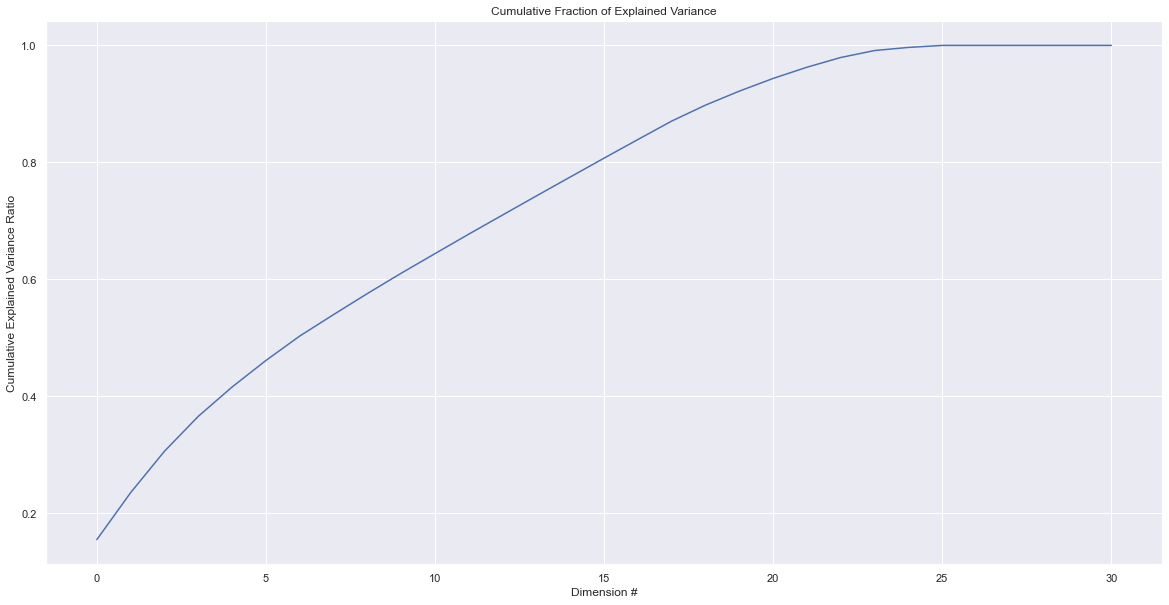

In [141]:
ax = plot_scaled_variance(pca)
ax.grid(True)

First 20 dimensions explain more than 90% of variance

In [147]:
pca2 = PCA(n_components = 20)
pca2.fit(df3)
reduced = pca2.transform(df3)
reduced.shape

Let's plot the first 3 dimensions to observe the clustering

In [154]:
hsv = plt.get_cmap('hsv')
clr = hsv(np.linspace(0, 1.0, 70))

In [155]:
cols = []
[cols.append('Feature '+ str(i)) for i in range(1, 21)]
cols.append('Cluster')

In [156]:
pc = pd.DataFrame(np.concatenate((reduced, y_kmeans.reshape((19093, 1))), axis=1), columns = cols)

In [312]:
pc.Cluster.value_counts()

27.0    879
2.0     825
29.0    718
52.0    626
22.0    599
       ... 
14.0     71
38.0     68
17.0     60
65.0     48
16.0     48
Name: Cluster, Length: 70, dtype: int64

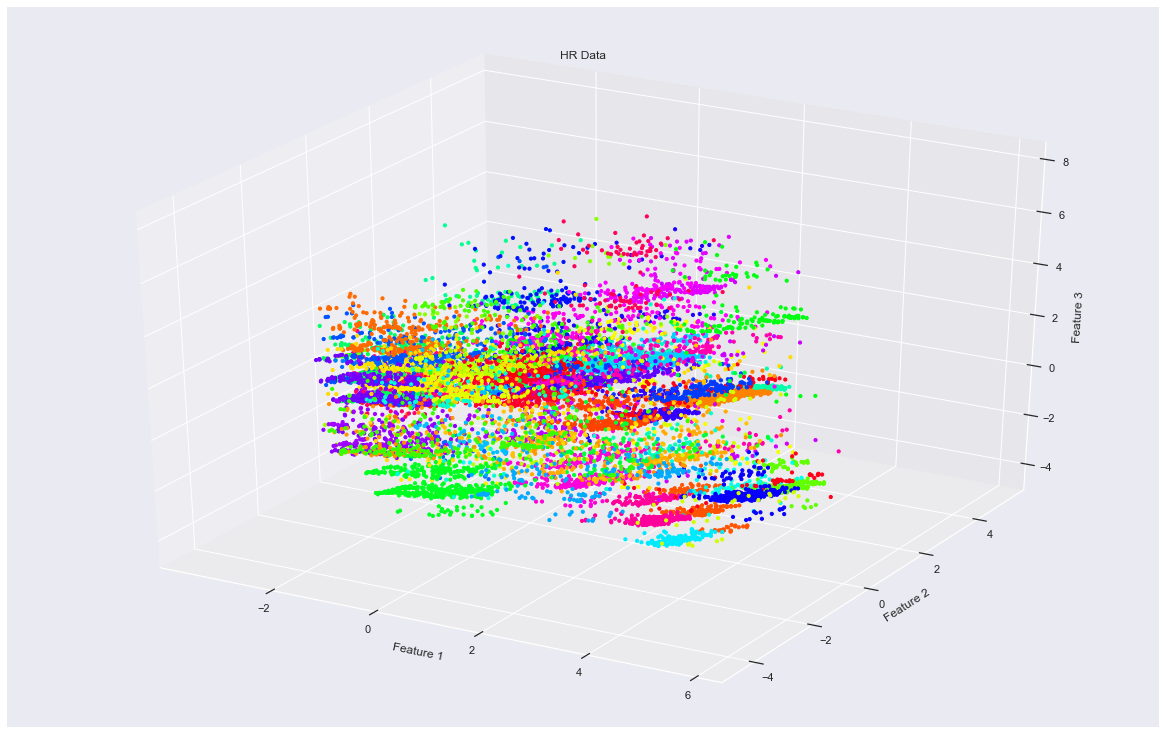

In [164]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(figsize=(16, 10))
ax = Axes3D(fig)
for c in range(70):
    tmp_df = pc[pc['Cluster'] == c]
    ax.scatter(tmp_df['Feature 1'], tmp_df['Feature 2'], tmp_df['Feature 3'], color=clr[c], label=c, alpha=1, s=10)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('HR Data')

sns.despine(offset=5, trim=True)
sns.set(font_scale=0.75)

Clustering appears to be in long cylindrical shapes. In that case, DBSCAN can lead to better results.

#### 3. DBSCAN

In [306]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.45, metric='euclidean', min_samples=20)
db.fit(reduced)

DBSCAN(eps=0.45, min_samples=20)

In [307]:
pc2 = pd.DataFrame(np.concatenate((reduced, db.labels_.reshape((19093, 1))), axis=1), columns = cols)

In [308]:
pc2.Cluster.value_counts()

-1.0     16851
 2.0       538
 3.0       204
 1.0       169
 4.0       140
 0.0       130
 12.0      107
 10.0       92
 6.0        90
 13.0       89
 9.0        88
 8.0        81
 7.0        79
 16.0       73
 5.0        69
 15.0       65
 14.0       41
 11.0       40
 20.0       36
 17.0       34
 18.0       29
 19.0       27
 21.0       21
Name: Cluster, dtype: int64

In [309]:
set(db.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21}

In [310]:
clr = hsv(np.linspace(0, 1.0, 22))

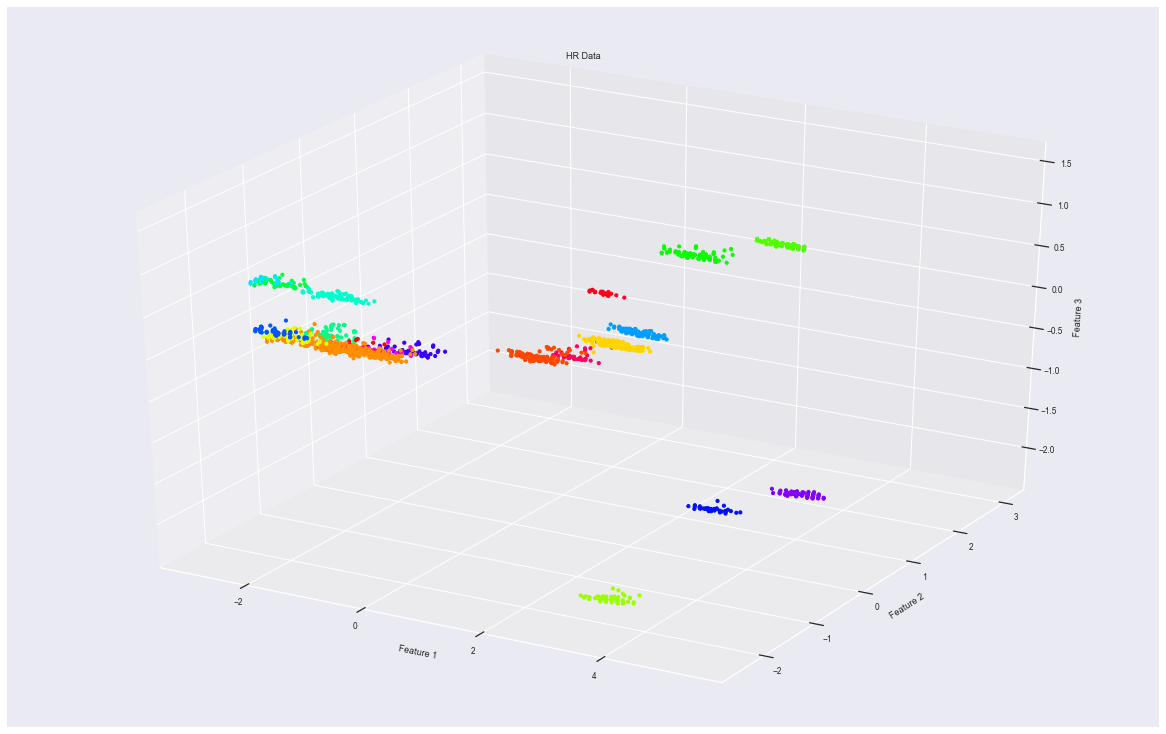

In [311]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(figsize=(16, 10))
ax = Axes3D(fig)
for c in range(22):
    tmp_df = pc2[pc2['Cluster'] == c]
    ax.scatter(tmp_df['Feature 1'], tmp_df['Feature 2'], tmp_df['Feature 3'], color=clr[c], label=c, alpha=1, s=10)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('HR Data')

sns.despine(offset=5, trim=True)
sns.set(font_scale=0.75)

With DBSCAN, as expected we see more distinguished clusters,with a large outlier population, but it is not possible to make 20 different models. 

# Models

In [129]:
############### SVM ####################

In [83]:
# Setup training / test data
from sklearn.metrics import classification_report
import sklearn.model_selection as cv
from sklearn import svm

#Setup x and y
y = df['target']
X = df.loc[:, df.columns != 'target']

#Test, train, split
(x_train, x_test, y_train, y_test) = cv.train_test_split(X, y, test_size=.25, random_state=1, stratify = y)

In [84]:
# Standardize the data for the classification

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [117]:
#Linear SVM
import sklearn.model_selection as cv
from sklearn import svm

svc = svm.SVC(kernel='linear', C=1)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred, \
                            target_names = ['Yes', 'No']))

#Does not work, which makes sense since the relationships among the variables are not linear

              precision    recall  f1-score   support

         Yes       0.75      1.00      0.86      3585
          No       0.00      0.00      0.00      1189

    accuracy                           0.75      4774
   macro avg       0.38      0.50      0.43      4774
weighted avg       0.56      0.75      0.64      4774



/Users/amadan72/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amadan72/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amadan72/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Poly Optimization
import sklearn.model_selection as cv
from sklearn import svm 
from sklearn.model_selection import GridSearchCV

svm = svm.SVC(kernel='poly')

# Instantiate the GridSearchCV object and run the search
parameters = {'degree':[1,2,3],'C':[0.5,1,1.5]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X, y)

# Report the best parameters
print("Selected params", searcher.best_params_)
#Poly SVC: When using poly kernel, the results were unstable. Sometimes works, sometimes does not

In [ ]:
#Poly SVC
import sklearn.model_selection as cv
from sklearn import svm

svc = svm.SVC(kernel='poly', degree=3, C=1)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred, \
                            target_names = ['Yes', 'No']))

#When using poly kernel, the results were unstable. Sometimes works, sometimes does not

In [ ]:
# RBF Optimization
import sklearn.model_selection as cv
from sklearn import svm 
from sklearn.model_selection import GridSearchCV

In [188]:
svm = svm.SVC(kernel='rbf')

# Instantiate the GridSearchCV object and run the search
parameters = {'gamma':[0.5,1,1.5],'C':[0.5,1,1.5]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X, y)

# Report the best parameters
print("Selected params", searcher.best_params_)

Selected params {'C': 1, 'gamma': 0.5}


In [187]:
#RBF SVC
import sklearn.model_selection as cv
from sklearn import svm

svc = svm.SVC(kernel='rbf', gamma=1, C=0.5,class_weight= 'balanced' )
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred, \
                            target_names = ['Yes', 'No']))


              precision    recall  f1-score   support

         Yes       0.83      0.83      0.83      3585
          No       0.49      0.49      0.49      1189

    accuracy                           0.75      4774
   macro avg       0.66      0.66      0.66      4774
weighted avg       0.75      0.75      0.75      4774



In [ ]:
### Random Forest ###

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

In [195]:
forest_model = RandomForestClassifier()

parameters = {'n_estimators' : [250,300],
              'max_depth' : [int(x) for x in np.linspace(30,35,6)],
              'min_samples_split' : [3,5],
              'min_samples_leaf' : [3,4],
              'max_features' : ['auto','sqrt'],
              'class_weight': ['None','balanced']
             }

In [160]:
y = df['target']
X = df.loc[:, df.columns != 'target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1, stratify = y)

In [100]:
# Standardize the data for the classification
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(x_train)
X_test = ss.transform(x_test)

In [196]:
import time
start_time = time.time()
search = GridSearchCV(forest_model,parameters,verbose=1, scoring = 'f1', n_jobs = -1)
search.fit(X_train,y_train)
print("Finished Grid search in %s seconds." % (time.time() - start_time))

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/Users/amadan72/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan     

Finished Grid search in 1879.9091610908508 seconds.


In [102]:
search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 32,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [103]:
forest_predictions = search.predict(X_test)

array([[2935,  650],
       [ 341,  848]])

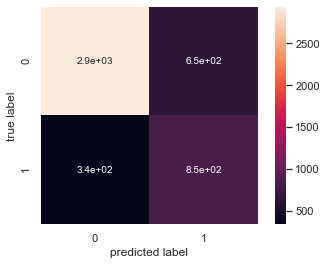

In [120]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score
cm = confusion_matrix(y_test,forest_predictions)
%matplotlib inline
sns.heatmap(cm,annot=True,square=True,cbar=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
cm

In [105]:
print(classification_report(y_test, forest_predictions))

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      3585
         1.0       0.57      0.71      0.63      1189

    accuracy                           0.79      4774
   macro avg       0.73      0.77      0.74      4774
weighted avg       0.81      0.79      0.80      4774



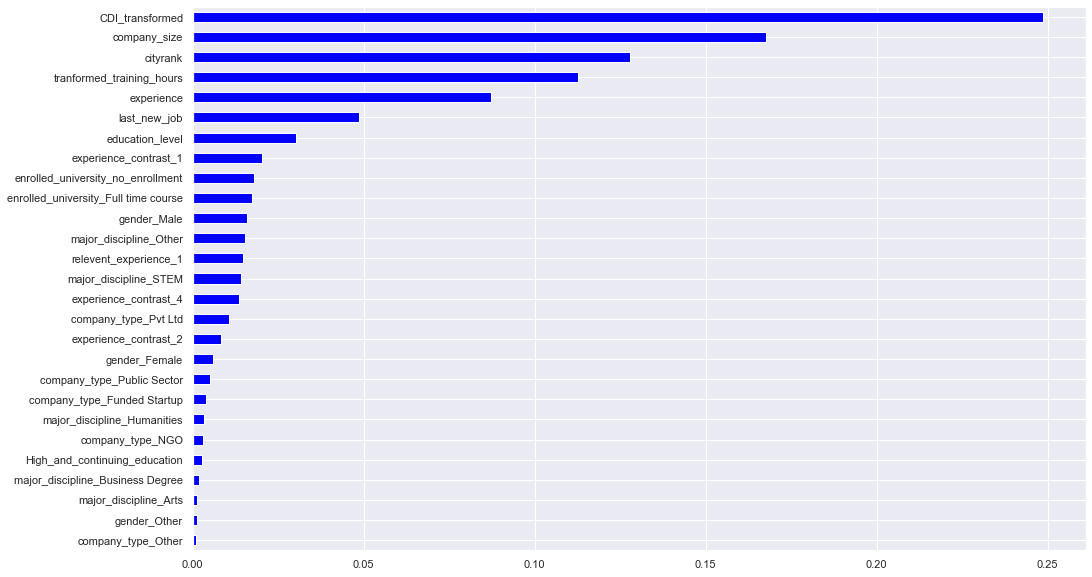

In [122]:
# Random forest feature importance
#Features importances
importances_rf = pd.Series(search.best_estimator_.feature_importances_, index = X.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='blue', figsize=(16, 10))
plt.show()

#Comment

In [124]:
acc_rf_cv = (cross_val_score(search.best_estimator_, X_train, y_train, cv=10, scoring='accuracy', n_jobs=1)).mean()
f1_rf_cv = (cross_val_score(search.best_estimator_, X_train, y_train, cv=10, scoring='f1', n_jobs=1)).mean()

In [125]:
rf_pred=search.best_estimator_.predict(X_test)
f1_rf = f1_score(y_test, rf_pred)
acc_rf = accuracy_score(y_test, rf_pred)

rf_pred_train=search.best_estimator_.predict(X_train)
f1_rf_train = f1_score(y_train, rf_pred_train)
acc_rf_train = accuracy_score(y_train, rf_pred_train)

In [126]:
print(f' Training Data Set Accuracy: {acc_rf_train:.3f}')
print(f' Training Data CV Accuracy: {acc_rf_cv:.3f}')
print(f' Test Data Set Accuracy: {acc_rf:.3f}')
print()
print(f' Training Data f1 Score: {f1_rf_train:.4f}')
print(f' Training Data CV f1 Score: {f1_rf_cv:.4f}')
print(f' Test Data Set f1 Score: {f1_rf:.4f}')

 Training Data Set Accuracy: 0.831
 Training Data CV Accuracy: 0.790
 Test Data Set Accuracy: 0.792

 Training Data f1 Score: 0.7037
 Training Data CV f1 Score: 0.6261
 Test Data Set f1 Score: 0.6312


Cross Validation scores are very close to test scores, although training set scores are higher indicating some overfitting.

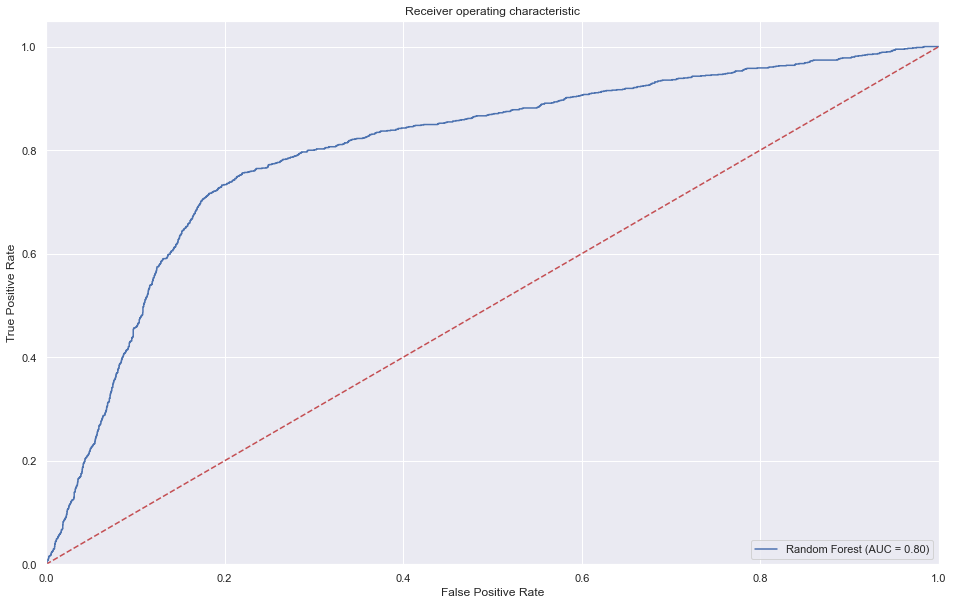

In [138]:
#ROC Curve
rf_roc_auc = roc_auc_score(y_test, search.best_estimator_.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, search.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize=(16, 10))
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### Trying SMOTE to improve the RF model ###

In [ ]:
# Setup training / test data
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as cv
from collections import Counter

#Setup x and y
y = df['target']
X_unscaled = df.loc[:, df.columns != 'target']

#Scale data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_unscaled.values), columns=X_unscaled.columns, index=X_unscaled.index)

#Test, train, split
(x_train, x_test, y_train, y_test) = cv.train_test_split(X, y, test_size=.25, random_state=1, stratify = y)
print("Before oversampling: ",Counter(y_train))

In [ ]:
from imblearn.over_sampling import SMOTE

smote_object = SMOTE()

x_train, y_train = smote_object.fit_resample(x_train, y_train)
print("After oversampling: ",Counter(y_train))

In [ ]:
import time
start_time = time.time()
search = GridSearchCV(forest_model,parameters,verbose=1, scoring = 'f1', n_jobs = -1)
search.fit(x_train,y_train)
print("Finished Grid search in %s seconds." % (time.time() - start_time))

In [197]:
search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 31,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [198]:
smote_predictions = search.predict(x_test)

array([[2626,  959],
       [ 519,  670]])

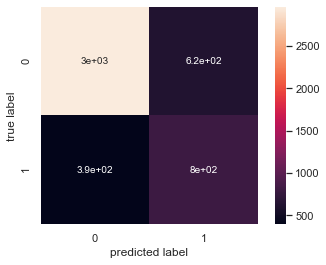

In [199]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score
cm2 = confusion_matrix(y_test,smote_predictions)
%matplotlib inline
sns.heatmap(cm2,annot=True,square=True,cbar=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
cm

In [200]:
print(classification_report(y_test, smote_predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85      3585
         1.0       0.56      0.67      0.61      1189

    accuracy                           0.79      4774
   macro avg       0.72      0.75      0.73      4774
weighted avg       0.80      0.79      0.79      4774



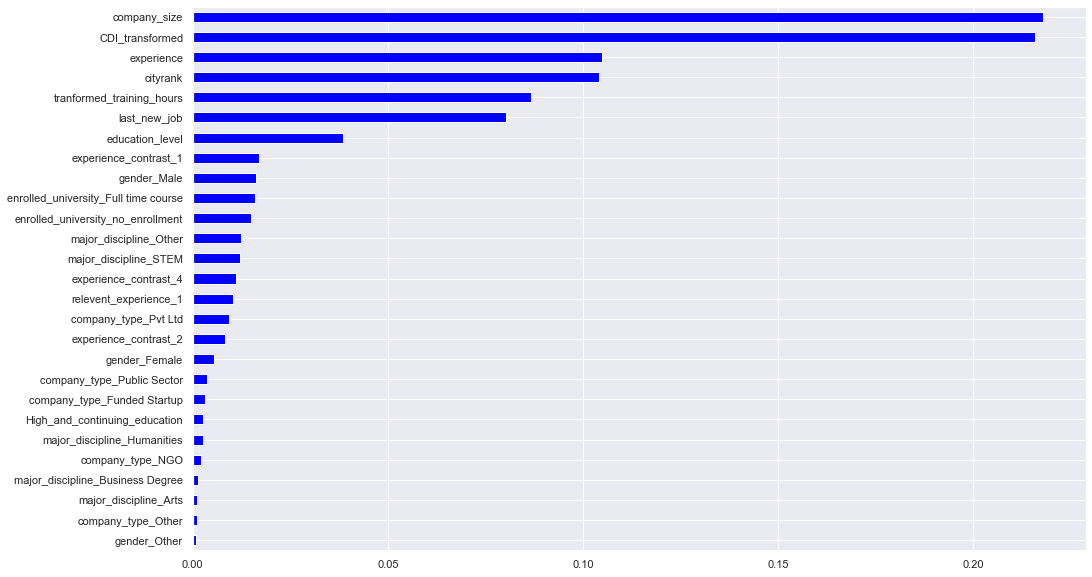

In [201]:
# Random forest feature importance
#Features importances
importances_smote = pd.Series(search.best_estimator_.feature_importances_, index = X.columns)

# Sort importances_rf
sorted_importances_smote = importances_smote.sort_values()

# Make a horizontal bar plot
sorted_importances_smote.plot(kind='barh', color='blue', figsize=(16, 10))
plt.show()

#Comment

In [202]:
acc_smote_cv = (cross_val_score(search.best_estimator_, x_train, y_train, cv=10, scoring='accuracy', n_jobs=1)).mean()
f1_smote_cv = (cross_val_score(search.best_estimator_, x_train, y_train, cv=10, scoring='f1', n_jobs=1)).mean()

In [205]:
smote_pred=search.best_estimator_.predict(x_test)
f1_smote = f1_score(y_test, smote_pred)
acc_smote = accuracy_score(y_test, smote_pred)

smote_pred_train=search.best_estimator_.predict(x_train)
f1_smote_train = f1_score(y_train, smote_pred_train)
acc_smote_train = accuracy_score(y_train, smote_pred_train)

In [206]:
print(f' Training Data Set Accuracy: {acc_smote_train:.3f}')
print(f' Training Data CV Accuracy: {acc_smote_cv:.3f}')
print(f' Test Data Set Accuracy: {acc_smote:.3f}')
print()
print(f' Training Data f1 Score: {f1_smote_train:.4f}')
print(f' Training Data CV f1 Score: {f1_smote_cv:.4f}')
print(f' Test Data Set f1 Score: {f1_smote:.4f}')

 Training Data Set Accuracy: 0.909
 Training Data CV Accuracy: 0.846
 Test Data Set Accuracy: 0.788

 Training Data f1 Score: 0.9105
 Training Data CV f1 Score: 0.8456
 Test Data Set f1 Score: 0.6112


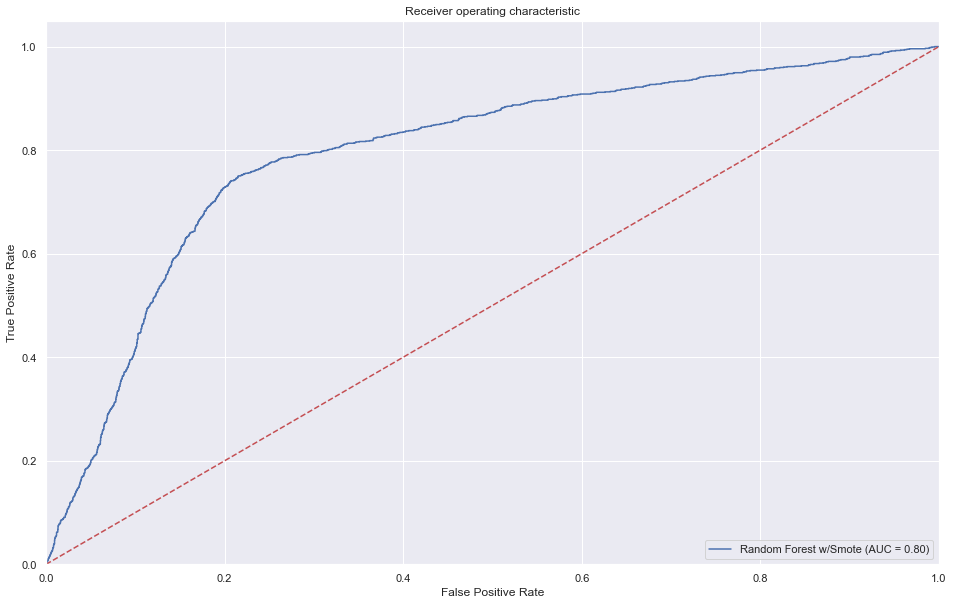

In [207]:
#ROC Curve
smote_roc_auc = roc_auc_score(y_test, search.best_estimator_.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, search.best_estimator_.predict_proba(x_test)[:,1])
plt.figure(figsize=(16, 10))
plt.plot(fpr, tpr, label='Random Forest w/Smote (AUC = %0.2f)' % smote_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### Logistic Regression ###

In [72]:
df.columns

Index(['education_level', 'experience', 'company_size', 'last_new_job',
       'target', 'enrolled_university_Full time course',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'major_discipline_Arts',
       'major_discipline_Business Degree', 'major_discipline_Humanities',
       'major_discipline_No Major', 'major_discipline_Other',
       'major_discipline_STEM', 'High_and_continuing_education', 'cityrank',
       'CDI_transformed', 'gender_Female', 'gender_Male', 'gender_Other',
       'experience_contrast_1', 'experience_contrast_2',
       'experience_contrast_3', 'experience_contrast_4',
       'relevent_experience_0', 'relevent_experience_1', 'log_training_hours',
       'company_type_Funded Startup', 'company_type_NGO', 'company_type_Other',
       'company_type_Public Sector', 'company_type_Pvt Ltd'],
      dtype='object')

In [73]:
#split dataset in features and target variable 
#drop a few features to reduce highly correlated relationship:  'experience_contrast_3', 'relevent_experience_0'. 
feature_cols=['education_level', 'experience', 'company_size', 'last_new_job','enrolled_university_Full time course',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'major_discipline_Arts',
       'major_discipline_Business Degree', 'major_discipline_Humanities',
       'major_discipline_No Major', 'major_discipline_Other',
       'major_discipline_STEM', 'High_and_continuing_education', 'cityrank',
       'CDI_transformed', 'gender_Female', 'gender_Male', 'gender_Other',
       'experience_contrast_1', 'experience_contrast_2','experience_contrast_4',
       'relevent_experience_1', 'log_training_hours',
       'company_type_Funded Startup', 'company_type_NGO', 'company_type_Other',
       'company_type_Public Sector', 'company_type_Pvt Ltd']
X = df[feature_cols] # Features
y = df['target'] # Target variable

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [80]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1, stratify = y)

In [83]:
# Standardize the data for the classification
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [84]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


In [86]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
#The result is telling us that we have 3363+207 correct predictions and 980+227 incorrect predictions.

[[3363  204]
 [ 980  227]]


In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
#Of the entire test set, 71% of the target prediction were accurate (The weighted average of F1 was used).
#The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 


              precision    recall  f1-score   support

         0.0       0.77      0.94      0.85      3567
         1.0       0.53      0.19      0.28      1207

    accuracy                           0.75      4774
   macro avg       0.65      0.57      0.56      4774
weighted avg       0.71      0.75      0.71      4774



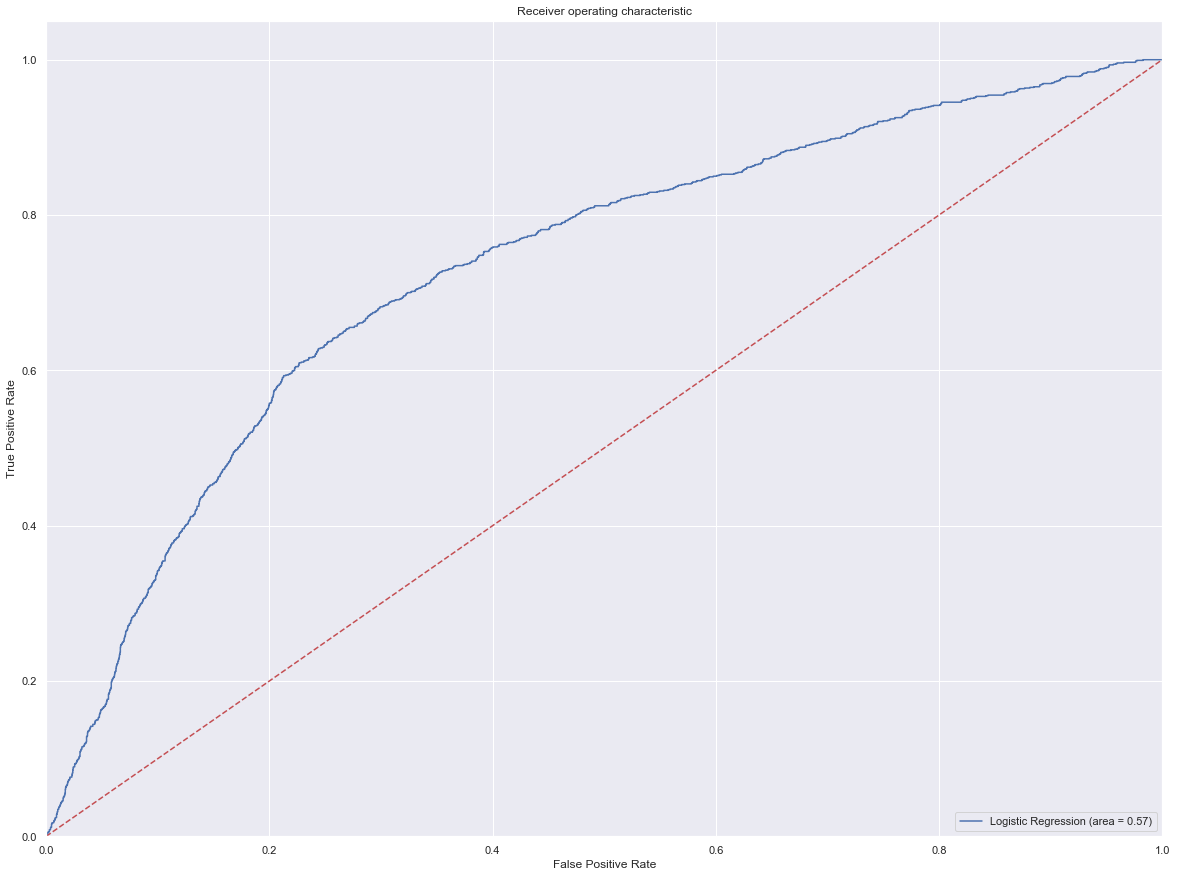

In [88]:
#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 1 is good, perfect classification. 0.5 is worthless.The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner). 

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score

y_pred = logreg .predict(X_train)
print("Training Data Set Accuracy: ", accuracy_score(y_train,y_pred))
print("Training Data F1 Score ", f1_score(y_train,y_pred))
print("Testing Mean Accuracy: ",cross_val_score(logreg,X_train,y_train,cv=5,scoring='accuracy').mean())
print("Testing Mean F1 Score: ",cross_val_score(logreg,X_train,y_train,cv=5,scoring='f1_macro').mean())

Training Data Set Accuracy:  0.7684894196522104
Training Data F1 Score  0.3106674984404242
Testing Mean Accuracy:  0.7666734311978878
Testing Mean F1 Score:  0.5826042515594947


Above metrics that Training Accuracy =Test Accuracy. Hence, model is performing well. 

In [ ]:
#Stoschastic Gradient Descent

In [163]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

In [164]:
y = df['target']
X = df.loc[:, df.columns != 'target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1, stratify = y)

In [165]:
# Standardize the data for the classification
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [166]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)


SGDClassifier()

In [167]:
acc_sgd = sgd.score(X_test, y_test) 
sgd_pred=sgd.predict(X_test)
f1_sgd = f1_score(y_test, sgd_pred)
sgd_pred_train=sgd.predict(X_train)
f1_sgd_train = f1_score(y_train, sgd_pred_train)
acc_sgd_train = accuracy_score(y_train, sgd_pred_train)

In [168]:
acc_sgd_cv = (cross_val_score(sgd, X_train, y_train, cv=10, scoring='accuracy', n_jobs=1)).mean()
f1_sgd_cv = (cross_val_score(sgd, X_train, y_train, cv=10, scoring='f1', n_jobs=1)).mean()

In [169]:
print(f' Training Data Set Accuracy: {acc_sgd_train:.3f}')
print(f' Training Data CV Accuracy: {acc_sgd_cv:.3f}')
print(f' Test Data Set Accuracy: {acc_sgd:.3f}')
print()
print(f' Training Data f1 Score: {f1_sgd_train:.4f}')
print(f' Training Data CV f1 Score: {f1_sgd_cv:.4f}')
print(f' Test Data Set f1 Score: {f1_sgd:.4f}')

 Training Data Set Accuracy: 0.752
 Training Data CV Accuracy: 0.752
 Test Data Set Accuracy: 0.755

 Training Data f1 Score: 0.0766
 Training Data CV f1 Score: 0.1853
 Test Data Set f1 Score: 0.0815


In [170]:
confusion_matrix(y_test,sgd_pred)


array([[3550,   35],
       [1137,   52]])

In [171]:
print(classification_report(y_test, sgd_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86      3585
         1.0       0.60      0.04      0.08      1189

    accuracy                           0.75      4774
   macro avg       0.68      0.52      0.47      4774
weighted avg       0.72      0.75      0.66      4774



In [178]:
parameters = {'loss' : ['hinge', 'modified_huber'],
              'penalty' : ['l2', 'l1'],
              'alpha' : [0.0003,0.0005,0.0007],
              'max_iter' : [1000,1500],
              'class_weight': [None,'balanced']
             }

In [179]:
import time
start_time = time.time()
search2 = GridSearchCV(sgd,parameters,verbose=1, scoring = 'f1', n_jobs = 1)
search2.fit(X_train,y_train)
print("Finished Grid search in %s seconds." % (time.time() - start_time))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Finished Grid search in 25.81521463394165 seconds.


In [180]:
search2.best_estimator_.get_params()

{'alpha': 0.0003,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1500,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

array([[2626,  959],
       [ 519,  670]])

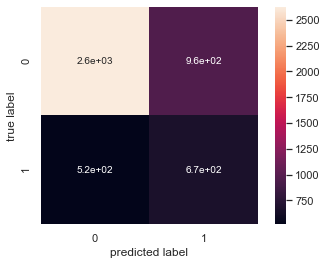

In [181]:
cm = confusion_matrix(y_test,search2.predict(X_test))
%matplotlib inline
sns.heatmap(cm,annot=True,square=True,cbar=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
cm

In [182]:
sgd_pred2 = search2.predict(X_test)
print(classification_report(y_test, sgd_pred2))

              precision    recall  f1-score   support

         0.0       0.83      0.73      0.78      3585
         1.0       0.41      0.56      0.48      1189

    accuracy                           0.69      4774
   macro avg       0.62      0.65      0.63      4774
weighted avg       0.73      0.69      0.70      4774



In [183]:
sgd_pred2 =search2.predict(X_test)
f1_sgd2 = f1_score(y_test, sgd_pred2)
acc_sgd2 = accuracy_score(y_test, sgd_pred2)

sgd_pred_train2 = search2.predict(X_train)
f1_sgd_train2 = f1_score(y_train, sgd_pred_train2)
acc_sgd_train2 = accuracy_score(y_train, sgd_pred_train2)

In [184]:
acc_sgd_cv2 = (cross_val_score(search2.best_estimator_, X_train, y_train, cv=10, scoring='accuracy', n_jobs=1)).mean()
f1_sgd_cv2 = (cross_val_score(search2.best_estimator_, X_train, y_train, cv=10, scoring='f1', n_jobs=1)).mean()

In [185]:
print(f' Training Data Set Accuracy: {acc_sgd_train2:.3f}')
print(f' Training Data CV Accuracy: {acc_sgd_cv2:.3f}')
print(f' Test Data Set Accuracy: {acc_sgd2:.3f}')
print()
print(f' Training Data f1 Score: {f1_sgd_train2:.4f}')
print(f' Training Data CV f1 Score: {f1_sgd_cv2:.4f}')
print(f' Test Data Set f1 Score: {f1_sgd2:.4f}')

 Training Data Set Accuracy: 0.700
 Training Data CV Accuracy: 0.688
 Test Data Set Accuracy: 0.690

 Training Data f1 Score: 0.4900
 Training Data CV f1 Score: 0.5032
 Test Data Set f1 Score: 0.4755


In [ ]:
####### knn Classifier #############

In [87]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,15)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(x_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(x_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(x_test, y_test) 

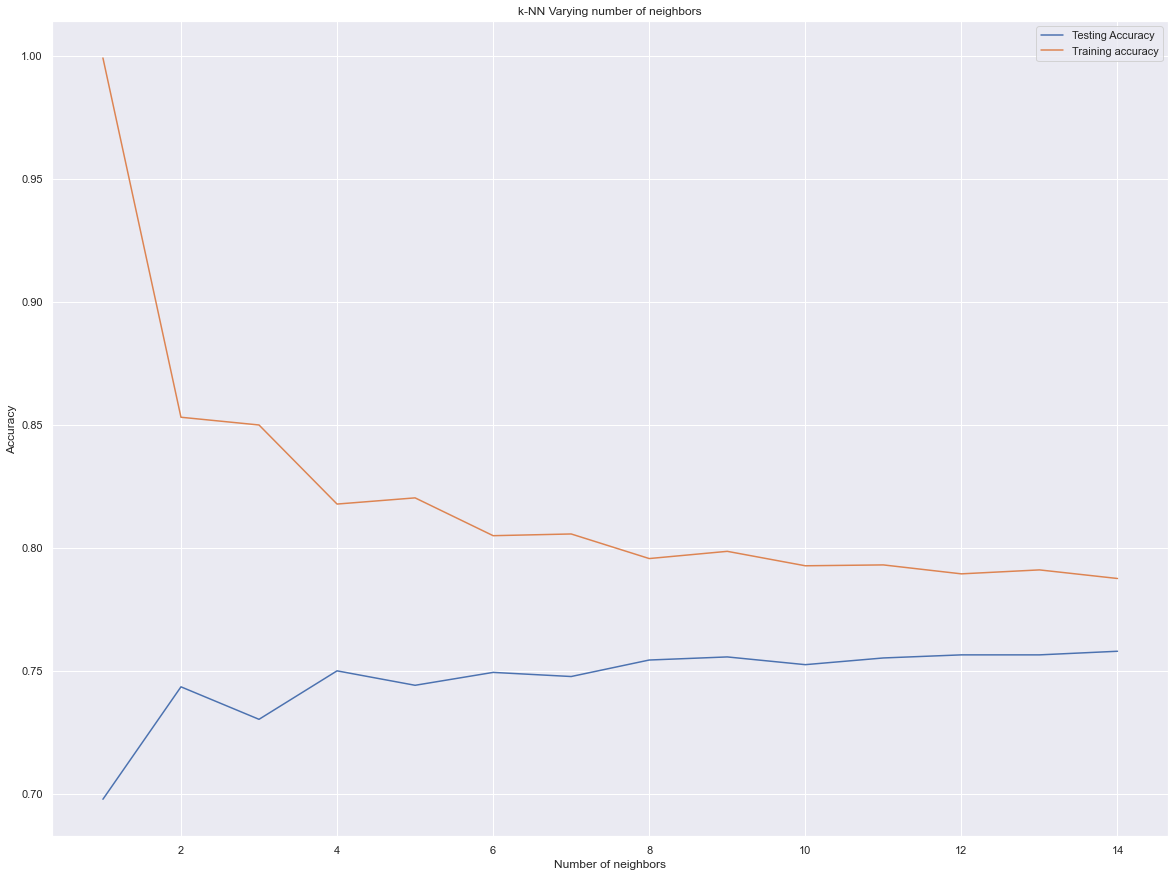

In [88]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [89]:
# Run model with selected number of classifiers
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train,y_train)

#Overall Score
print(knn.score(x_test,y_test))

#Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_test)

print(confusion_matrix(y_test,y_pred))

0.7526183493925429
[[3316  269]
 [ 912  277]]


In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.92      0.85      3585
         1.0       0.51      0.23      0.32      1189

    accuracy                           0.75      4774
   macro avg       0.65      0.58      0.58      4774
weighted avg       0.72      0.75      0.72      4774

